# Libraries

In [1]:
import pandas as pd
import numpy as np
import os as os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Load train data

- iterate through train data folder 
- feature engineer the **country** and **league** from parent folder name
- join the loaded csv files by rows

In [2]:
df = pd.DataFrame()
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            # Remove empty rows and columns
            tmp = tmp.dropna(how='all', axis=0)
            tmp = tmp.dropna(how='all', axis=1)
            # Derive additional columns
            tmp["league"] = int(root.split("\\")[2])
            tmp["country"] = root.split("\\")[1]
            tmp["season"] = int(file[:2]) # no. of season - 00/01 - 0th season, 21/22 - 21st season
            df = pd.concat([df, tmp], axis = 0)

df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBAHA,LBAH,LB,LB.1,LB.2,HT,AT,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,B1,20/05/01,Mechelen,Lierse,1.0,1.0,D,1.0,1.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,17/09/00,Germinal,Club Brugge,2.0,3.0,A,0.0,1.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B1,14/10/00,Beveren,Standard,0.0,3.0,A,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B1,06/09/00,Lokeren,Mechelen,3.0,2.0,H,0.0,2.0,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B1,27/08/00,Charleroi,Antwerp,1.0,0.0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data validation

In some cases, the data is wrong. This section correct the loaded data.

## Not imputable data

In some cases, missing data cause the data to be unusable and can't be computed. This applies to variables

- HomeTeam
- AwayTeam

In [3]:
crucial_cols = ['Date', 'HomeTeam', 'AwayTeam']
df = df.dropna(subset = crucial_cols)

## Goal validation

Some goals are incorrect and they need to be fixed.



In [4]:
goal_cols = ["FTHG", "FTAG", "HTHG", "HTAG"]
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,153476.000000,153458.000000,153426.000000,153433.000000
mean,2.221813,1.131671,0.655032,0.494333
std,21.960074,1.109022,0.808892,0.708273
min,0.000000,-1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,998.000000,13.000000,7.000000,6.000000


There seems to be several issues:

- the max value for **FTHG** is absurd
- the min value for **FTAG** does not make sense
- some values are missing

In [5]:
df["FTHG"].value_counts().head(12)

FTHG
1.0      51309
2.0      37397
0.0      35796
3.0      18313
4.0       7154
5.0       2325
6.0        741
7.0        182
8.0         41
9.0         14
10.0         5
339.0        5
Name: count, dtype: int64

First, we will remove all rows where the Full Time Home Goals are greater than 10.

In [6]:
df = df[df["FTHG"] <= 10]

Next, all Full Time Away goals that are less than zero are inspected. Since we are not sure which values are good and bad, all of them are removed.

In [7]:
df = df[df["FTAG"] >= 0]

What's left are the missing values. We have no way of recomputing these as well and these rows are again excluded.

In [8]:
df = df[df[goal_cols].isna().sum(axis=1) == 0]

If we run the describe() function again, we can see that the counts are the same and min/max statistics make sense.

In [9]:
df[goal_cols].describe()

,FTHG,FTAG,HTHG,HTAG
count,152796.000000,152796.000000,152796.000000,152796.000000
mean,1.484699,1.134284,0.655096,0.494496
std,1.252576,1.107143,0.808871,0.708516
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,2.000000,2.000000,1.000000,1.000000
max,10.000000,13.000000,7.000000,6.000000


## Result validation

Another thing that needs to be validated is the result classification, which are re-classified - this is the easiest data validation process.

In [10]:
half_conds = [df["HTHG"] > df["HTAG"], df["HTHG"] < df["HTAG"], df["HTHG"] == df["HTAG"]]
half_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "HTR"] = np.select(half_conds, half_choic)
full_conds = [df["FTHG"] > df["FTAG"], df["FTHG"] < df["FTAG"], df["FTHG"] == df["FTAG"]]
full_choic = ["H"                    , "A"                    , "D"]
df.loc[:, "FTR"] = np.select(full_conds, full_choic)

## Validation of other statistics

First step is to look at simple descriptive statistics.

!! proč je hfkc/afkc plný na??

In [79]:
stat_cols = [
    'Attendance', 'HS', 'AS', 'HST', 'AST', 'HHW', 'AHW',
    'HC', 'AC', 'HF', 'AF', 'HFKC', 'AFKC', 'HO', 'AO', 'HY', 'AY', 'HR', 'AR'
]

df[stat_cols].describe()

,Attendance,HS,AS,HST,AST,HHW,AHW,HC,AC,HF,AF,HFKC,AFKC,HO,AO,HY,AY,HR,AR
count,6447.000000,6456.000000,6456.000000,6450.000000,6456.000000,6444.000000,6456.000000,6424.000000,6456.000000,6456.000000,6456.000000,0.0,0.0,6456.000000,6437.000000,6456.000000,6456.000000,6456.000000,6456.000000
mean,12956.602916,12.164188,9.222119,5.836589,4.326053,0.352421,0.259603,6.028487,4.752014,13.098513,13.865706,NaN,NaN,3.259758,3.250738,1.337051,1.771840,0.081165,0.124845
std,14026.940200,4.468392,3.767271,2.744503,2.309602,0.611171,0.529955,2.956053,2.654140,4.548241,4.694651,NaN,NaN,2.366739,2.520004,1.173459,1.313395,0.294402,0.361890
min,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3477.500000,9.000000,7.000000,4.000000,3.000000,0.000000,0.000000,4.000000,3.000000,10.000000,11.000000,NaN,NaN,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,7000.000000,12.000000,9.000000,6.000000,4.000000,0.000000,0.000000,6.000000,4.000000,13.000000,13.000000,NaN,NaN,3.000000,3.000000,1.000000,2.000000,0.000000,0.000000
75%,18000.000000,15.000000,12.000000,7.000000,6.000000,1.000000,0.000000,8.000000,6.000000,16.000000,17.000000,NaN,NaN,5.000000,5.000000,2.000000,3.000000,0.000000,0.000000
max,69000.000000,41.000000,30.000000,20.000000,18.000000,4.000000,4.000000,19.000000,18.000000,35.000000,36.000000,NaN,NaN,16.000000,18.000000,7.000000,10.000000,3.000000,4.000000


Then we take a look at boxplots for variables where at least one variable falls out of the interval

$$
(\text{q}_{0.25} - 3 * \text{IQR},\space \text{q}_{0.75} + 3 * \text{IQR})
$$

In [80]:
def outliers(x, multi = 3):
    q25 = x.quantile(0.25)
    q75 = x.quantile(0.75)
    iqr = q75 - q25
    outliers = x[(x < q25 - multi * iqr) | (x > q75 + multi * iqr)]
    return len(outliers)

stat_outliers = df[stat_cols].apply(lambda x: outliers(x))
stat_outliers = stat_outliers[stat_outliers != 0]
stat_outliers

Attendance      77
HS               1
AS               3
HST             13
AST              1
AHW           1428
AC               6
HF               1
AF               1
HO               4
AO               2
AY               2
HR             488
AR             743
dtype: int64

!!!
Bylo by cool se přidat nějak jitter těch bodů, aby bylo vidět, jestli je jeden nebo je jich víc, ale nepodařilo se mi to dát dohromady.

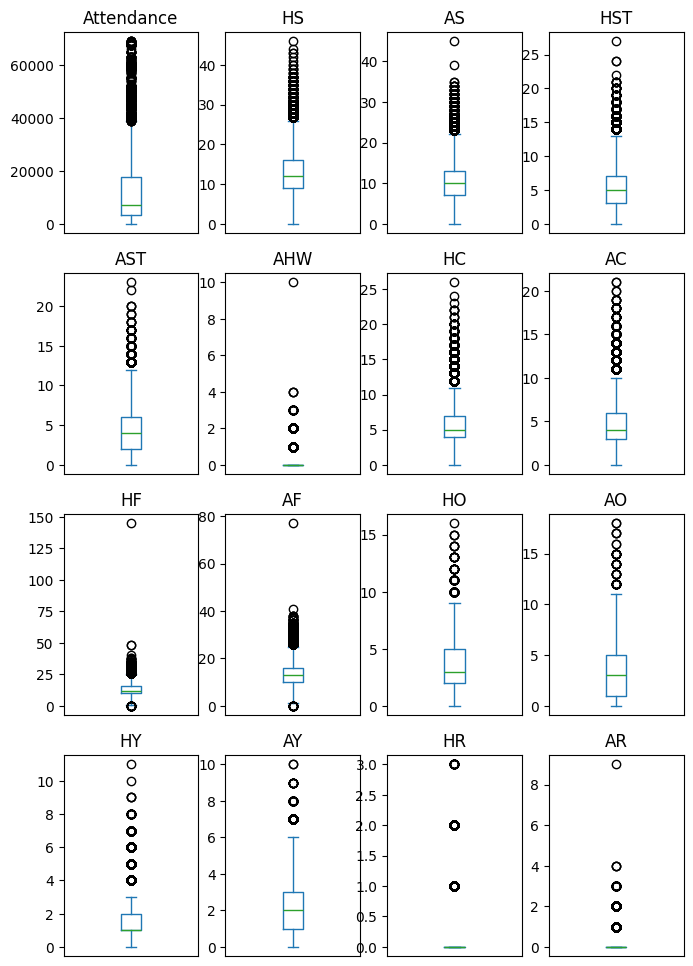

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Replace 'df' with the name of your DataFrame

fig, axes = plt.subplots(nrows=4, ncols = 4, figsize = (8, 12))
axes = axes.ravel()

for i, col in enumerate(stat_outliers.index):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()


We can se that some outliers are not that extreme. For example variables *HO*, *AO* or *HY* have extreme values, but won't remove them. This is because even tho they can be considered as extreme, there seems to be a natural way how they occured and tehre are no huge jumps between them.

On the other hand, variables *AHW*, *HF*, *AF* and *AR* seem to have some variables that are far away from the other data. Note that we do not consider variables in *HR* as outliers because it looks like it's a discrete variable with mostly zeros.

In [66]:
stat_jump = [
    "AS", "AHW", "HF", "AF", "AR"
]
stats_cut = [
    38, 6, 100, 60, 6
]

print("Number of extreme values:")
for i, col in enumerate(stat_jump):
    cutoff = stats_cut[i]
    x = df[col].to_numpy()
    extreme = x[x > cutoff]
    print(f"{col}: {extreme}, (count: {len(extreme)})")
    
plt.show()

Number of extreme values:
AS: [45. 39.], (count: 2)
AHW: [10.], (count: 1)
HF: [145.], (count: 1)
AF: [77.], (count: 1)
AR: [9.], (count: 1)


Based on the analysis, we see that these extreme values occur at most twise. This is why we chose to remove them.

In [68]:
criteria = dict(zip(stat_jump, stats_cut))
for column, value in criteria.items():
    df = df[df[column] < value]

Finally, we will double-check with boxplots.

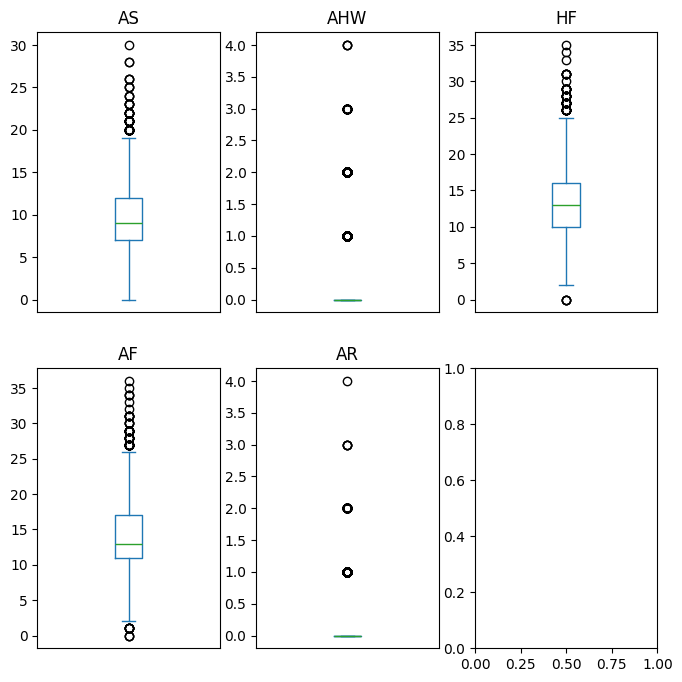

In [74]:
fig, axes = plt.subplots(nrows=2, ncols = 3, figsize = (8, 8))
axes = axes.ravel()

for i, col in enumerate(stat_jump):
    # Data
    df[col].plot(kind='box', ax = axes[i])
    # Styling
    axes[i].set_title(col)
    axes[i].axes.get_xaxis().set_visible(False)

plt.show()

In [77]:
df["Referee"].value_counts()

Referee
John Rowbotham      35
Paul Durkin         33
Jeff Winter         33
Paul Danson         32
Michael Jones       32
                    ..
G. B. Frankland      1
D Penton             1
P. E. Alcock         1
M.Clattenberg        1
I Brines             1
Name: count, Length: 687, dtype: int64

## Random unnamed data

File *'data/train/portugal/1/0304.csv'* contains random data in columns *'Unnamed: 33'* and *'Unnamed: 34'*.

In [293]:
unnamed_cols_df = df[['Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34']]
unnamed_cols_df[unnamed_cols_df.notnull().any(axis=1)]

,Unnamed: 32,Unnamed: 33,Unnamed: 34
157,2.0,1.8,-1.75


Since we do not know what these columns represent, and it is only one non-NA row from the whole dataset, this column is removed.

In [294]:
df = df.drop(columns = unnamed_cols_df.columns)

## Wrong betting odds names

File *'data/train/germany/2/0405.csv'* contains columns **LB**, **LB.1** and **LB.2**, which are unique only to this file. After further investigation, they represent the betting odds data for Ladbrokers. After looking at the data more thoroughly, it can be guessed that all three columns represent odds for home win, away win, and draw.

In [295]:
tmp = pd.read_csv("data/train/germany/2/0405.csv")
# Remove empty rows and columns
tmp = tmp.dropna(how='all', axis=0)
tmp = tmp.dropna(how='all', axis=1)
tmp = tmp.loc[:, ~tmp.columns.str.startswith('Unnamed:')]
tmp = tmp[tmp[['LB', 'LB.1', 'LB.2']].notnull().any(axis=1)]
tmp.filter(regex='[HDAB12]$').iloc[:, -12:]

,LB,LB.1,LB.2,SBH,SBD,SBA,WHH,WHD,WHA,GBAHH,GBAHA,GBAH
2,1.67,3.25,NaN,1.62,3.75,5.00,1.65,3.30,4.60,1.65,2.02,-0.50
6,2.00,3.20,NaN,2.10,3.20,3.25,2.15,3.10,3.00,1.77,1.95,-0.25
7,1.91,3.25,NaN,2.00,3.30,3.40,1.90,3.25,3.40,1.95,1.70,-0.50
12,2.60,3.20,2.38,2.70,3.20,2.40,2.50,3.10,2.50,1.43,2.50,0.50
15,2.25,3.20,2.75,2.40,3.00,2.88,2.20,3.10,2.87,2.30,1.48,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...
291,2.40,3.25,2.50,2.50,3.25,2.50,2.45,3.25,2.45,2.45,1.43,-0.50
294,2.00,3.00,3.40,2.10,3.20,3.25,2.10,3.20,3.00,1.91,1.70,-0.50
295,2.25,3.20,2.75,2.38,3.10,2.88,2.37,3.30,2.50,2.20,1.52,-0.50
297,1.62,3.25,5.00,1.60,3.75,5.00,1.60,3.30,5.00,1.62,2.06,-0.50


Based on column similarity, we can make an edjucated guess that

- **LB** should be **LBH**,
- **LB.1** should be **LBD**, and
- **LB.2** should be **LBA**

In [296]:
# If LB is not null, use that value and replace it in LBH
df["LBH"] = df["LBH"].mask(df["LB"  ].notnull(), df["LB"])
df["LBD"] = df["LBD"].mask(df["LB.1"].notnull(), df["LB.1"])
df["LBA"] = df["LBA"].mask(df["LB.2"].notnull(), df["LB.2"])
df = df.drop(columns = ["LB", "LB.1", "LB.2"])

## Same name for different things

In some cases, columns are named differently. We will standardize to use column names that are in *'notes.txt'*


In [297]:
for root, directory, files in os.walk("data/train", topdown=False):
    if files:
        for file in files:
            tmp = pd.read_csv(f"{root}/{file}")
            if "HT" in tmp.columns:
                print(f"Cases for HT: {root}, {file}")
            if "AT" in tmp.columns:
                print(f"Cases for AT: {root}, {file}")

Cases for HT: data/train\greece\1, 0001.csv
Cases for AT: data/train\greece\1, 0001.csv
Cases for HT: data/train\greece\1, 0102.csv
Cases for AT: data/train\greece\1, 0102.csv
Cases for HT: data/train\greece\1, 0203.csv
Cases for AT: data/train\greece\1, 0203.csv
Cases for HT: data/train\greece\1, 0304.csv
Cases for AT: data/train\greece\1, 0304.csv
Cases for HT: data/train\greece\1, 0405.csv
Cases for AT: data/train\greece\1, 0405.csv


The only affected data are in Greece.

In [298]:
df["HomeTeam"] = df["HomeTeam"].mask(df["HT"].notnull(), df["HT"])
df["AwayTeam"] = df["AwayTeam"].mask(df["AT"].notnull(), df["AT"])
df = df.drop(columns = ["HT", "AT"])

## Date normalization

Date is not consistent and it needs to be unified in order to format it as date.

In [299]:
potential_fixes = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)
equal = potential_fixes[potential_fixes.isnull()].index.equals(df[df["Date"].isnull()].index)
# if True, all non-na dates have been converted
if equal:
    df["Date"] = potential_fixes
else:
    sys.exit("Date indexes are not equal. Something wrong with the conversion??")

- - -

In [300]:
df.shape

(152796, 166)

Drop all completely empty columns and rows which there is a lot of, dropped 41 empty columns in total.

In [89]:
df.dropna(how='all', axis=1, inplace=True)

In [90]:
df.shape

(154953, 166)

In [91]:
df.to_csv("final.csv")

# Data Exploration

Total overview of all variables.

In [92]:
df.describe()

,FTHG,FTAG,HTHG,HTAG,GBH,GBD,GBA,IWH,IWD,IWA,...,HO,AO,HBP,ABP,SOH,SOD,SOA,LBAHH,LBAHA,LBAH
count,154864.000000,154841.000000,154813.000000,154820.000000,88060.000000,88123.000000,88106.000000,150729.000000,150735.000000,150766.000000,...,6520.000000,6499.000000,6687.000000,6671.000000,6599.000000,6613.000000,6614.000000,5470.000000,5470.000000,5458.000000
mean,2.216358,1.130883,0.655636,0.494206,2.275366,3.381363,3.950892,2.335784,3.382514,3.753866,...,3.262423,3.250346,15.494990,20.914406,2.216488,3.391382,3.833776,1.911200,1.924793,-0.350500
std,21.861876,1.108967,0.809382,0.708167,1.039952,0.613622,2.195107,1.155085,0.713629,2.251540,...,2.371017,2.516174,14.985842,17.212936,0.983779,0.481409,2.078919,0.174042,0.124442,0.588259
min,0.000000,-1.000000,0.000000,0.000000,1.030000,1.250000,1.030000,1.010000,1.500000,1.030000,...,0.000000,0.000000,0.000000,0.000000,1.060000,2.380000,1.140000,-2.250000,-0.500000,-2.250000
25%,1.000000,0.000000,0.000000,0.000000,1.730000,3.100000,2.650000,1.750000,3.050000,2.550000,...,2.000000,1.000000,0.000000,10.000000,1.700000,3.200000,2.620000,1.840000,1.840000,-0.750000
50%,1.000000,1.000000,0.000000,0.000000,2.100000,3.250000,3.350000,2.100000,3.200000,3.200000,...,3.000000,3.000000,10.000000,20.000000,2.100000,3.250000,3.250000,1.920000,1.920000,-0.250000
75%,2.000000,2.000000,1.000000,1.000000,2.450000,3.450000,4.500000,2.500000,3.450000,4.200000,...,5.000000,5.000000,20.000000,30.000000,2.400000,3.400000,4.500000,2.000000,2.000000,0.000000
max,998.000000,13.000000,7.000000,6.000000,24.000000,11.000000,34.000000,30.000000,16.000000,70.000000,...,16.000000,18.000000,115.000000,150.000000,13.000000,8.000000,21.000000,3.400000,4.000000,9.000000


Percentage of missing values.

In [93]:
na_vals = df.isna().sum()
na_vals = na_vals/df.shape[0]
na_vals = na_vals.sort_values()
na_vals.sort_values(ascending = False).head(20)

HFKC          0.991572
AFKC          0.991572
SYD           0.964809
LBAH          0.964776
SYA           0.964757
SYH           0.964757
LBAHH         0.964699
LBAHA         0.964699
AO            0.958058
HHW           0.958007
AHW           0.957929
HO            0.957923
SOH           0.957413
SOD           0.957323
SOA           0.957316
ABP           0.956948
Attendance    0.956916
HBP           0.956845
B365AH        0.955735
GBAHA         0.924880
dtype: float64

In [179]:
df = df.reset_index(drop = True)

# Get first and last occurrences
first_occurrences = df.apply(lambda x: x.first_valid_index())
last_occurrences = df.apply(lambda x: x.last_valid_index())

# Initialize a dictionary to store counts
missing_counts = {}

# Iterate through each column and calculate missing values counts between first and last occurrences
for column in df.columns:
    # Indexes of the first and last occurrences
    first_idx = df[column].first_valid_index()
    last_idx = df[column].last_valid_index()

    # Select the range between first and last occurrence, count missing values
    missing_count = df[column][first_idx:last_idx].isnull().sum()
    missing_counts[column] = missing_count

# Create a new DataFrame with the results
result_df = pd.DataFrame({
    'Variable':          df.columns,
    'First Occurrence':  df["Date"].to_numpy()[first_occurrences.values],
    'Last Occurrence':   df["Date"].to_numpy()[last_occurrences.values],
    "Missing within": missing_counts.values()
})

result_df

,Variable,First Occurrence,Last Occurrence,Missing within
0,Div,2001-05-20,2022-05-15,91
1,Date,2001-05-20,2022-05-15,147
2,HomeTeam,2001-05-20,2022-05-15,69
3,AwayTeam,2001-05-20,2022-05-15,65
4,FTHG,2001-05-20,2022-05-15,89
...,...,...,...,...
162,SOA,2002-09-14,2003-12-21,118363
163,LBAHH,2003-09-20,2004-10-17,128097
164,LBAHA,2003-09-20,2004-10-17,128097
165,LBAH,2003-09-20,2004-10-17,128109


List of the most missing values.

In [19]:
na_vals = df[df["season"] > 18].isna().sum()

na_vals = na_vals/df[df["season"] > 18].shape[0]*100
na_vals

Div           0.000000
Date          0.087754
HomeTeam      0.000000
AwayTeam      0.000000
FTHG          0.034126
               ...    
SOD         100.000000
SOA         100.000000
LBAHH       100.000000
LBAHA       100.000000
LBAH        100.000000
Length: 166, dtype: float64

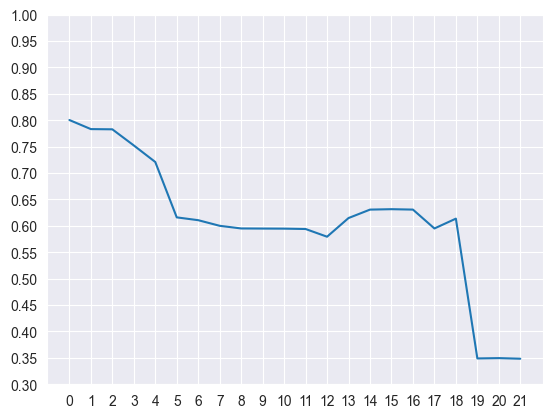

In [20]:
na_vals = [df[df["season"]==i].isna().sum().sum()/(df[df["season"]==i].shape[0]*df[df["season"]==i].shape[1]) for i in range(0,22)]
plt.xticks(range(0,22))
plt.ylim(0.3, 1)
plt.locator_params(axis='y', nbins=14)
plt.plot(na_vals)
plt.gca().ticklabel_format(axis='y', style='plain', scilimits=(0, 0))